In [160]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from decifer.utility import pxrd_from_cif
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms

def combined_analysis_and_visualization(result_path, param_name, standard_pxrd_params=None, prefix="", folder="figures", show_exp_params=False):
    
    # Load data
    with open(result_path, "rb") as f:
        data = pickle.load(f)
    results = data["results"]
    
    # Ensure the output folder exists.
    os.makedirs(folder, exist_ok=True)

    aggregated = {}
    for combo_key, exp_list in results.items():
        for exp in exp_list:
            if param_name not in exp["params"]:
                continue  # Skip if param_name is missing (when combinatory=False)
            
            param_val = exp["params"][param_name]
            if param_val not in aggregated:
                aggregated[param_val] = {"valid": [], "rwp": []}
            # Validity as percentage: 100 if valid, 0 otherwise.
            aggregated[param_val]["valid"].append(100 * (1 if exp["val"] else 0))
            aggregated[param_val]["rwp"].append(exp["rwp"])
    
    if not aggregated:
        print(f"No valid data found for parameter: {param_name}")
        return

    # Sort the parameter values and calculate statistics.
    sorted_param_vals = sorted(aggregated.keys())
    validity_means, validity_stds, rwp_means, rwp_stds = [], [], [], []
    for val in sorted_param_vals:
        valid_vals = np.array(aggregated[val]["valid"])
        rwp_vals = np.array(aggregated[val]["rwp"])
        validity_means.append(np.mean(valid_vals))
        validity_stds.append(np.std(valid_vals))
        rwp_means.append(np.mean(rwp_vals))
        rwp_stds.append(np.std(rwp_vals))
    
    sorted_param_vals = np.array(sorted_param_vals)
    validity_means = np.array(validity_means)
    validity_stds = np.array(validity_stds)
    rwp_means = np.array(rwp_means)
    rwp_stds = np.array(rwp_stds)
    
    # Create the dual y-axis aggregated plot.
    fig, ax1 = plt.subplots(figsize=(6, 6))
    ax2 = ax1.twinx()
    ax1.plot(sorted_param_vals, validity_means, 'o-', color='blue', label="Validity (%)")
    ax1.fill_between(sorted_param_vals, validity_means - validity_stds, validity_means + validity_stds,
                     color='blue', alpha=0.3)
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Validity (%)", color="blue")
    ax1.set_xscale("log")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    ax2.plot(sorted_param_vals, rwp_means, 'o-', color='green', label="RWP")
    ax2.fill_between(sorted_param_vals, rwp_means - rwp_stds, rwp_means + rwp_stds,
                     color='green', alpha=0.3)
    ax2.set_ylabel("RWP", color="green")
    ax2.set_xscale("log")
    ax2.tick_params(axis='y', labelcolor="green")
    
    # Combine legends from both axes.
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    
    plt.title(f"Validity and RWP vs. {param_name} (Aggregated)")
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(folder, f"{prefix}_validity_rwp.png"))
    
    if standard_pxrd_params is None:
        standard_pxrd_params = {
            "qmin": 0.0,
            "qmax": 10.0,
            "qstep": 0.01,
            "base_fwhm": 0.1,
            "eta": 0.5
        }
    
    # Select the best result (lowest rwp) for each unique parameter value.
    best_results = {}
    for combo_key, exp_list in results.items():
        if param_name not in exp_list[0]["params"]:
            continue
        
        param_val = exp_list[0]['params'][param_name]
        best_result = min(exp_list, key=lambda x: x['rwp'])
        best_results[param_val] = best_result

    sorted_param_vals = sorted(best_results.keys())
    
    for val in sorted_param_vals:
        res = best_results[val]
        
        # Retrieve the reference and generated structures.
        ref_struct = res["reference_structure"]
        gen_struct = res["generated_structure"]
        
        # Retrieve the PXRD results computed with experiment parameters.
        pxrd_exp_ref = res["pxrd_ref"]
        pxrd_exp_gen = res["pxrd_gen"]
        
        # Compute the standard PXRD for both reference and generated structures.
        pxrd_std_ref = pxrd_from_cif(res["reference_cif"], debug=True, **standard_pxrd_params)
        pxrd_std_gen = pxrd_from_cif(res["generated_cif"], debug=True, **standard_pxrd_params)
        
        # Create a figure using GridSpec:
        fig = plt.figure(figsize=(8, 10))
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
        ax_pxrd = fig.add_subplot(gs[0, :])
        ax_ref = fig.add_subplot(gs[1, 0])
        ax_gen = fig.add_subplot(gs[1, 1])
        
        # Top row: PXRD comparison spanning full width.
        ax_pxrd.plot(pxrd_exp_ref["q"], pxrd_exp_ref["iq"], label="Ref PXRD (Exp Params)", color="black", lw=2)
        if show_exp_params:
            ax_pxrd.plot(pxrd_exp_gen["q"], pxrd_exp_gen["iq"], label="Gen PXRD (Exp Params)", color="red", lw=2)
        ax_pxrd.plot(pxrd_std_ref["q"], pxrd_std_ref["iq"], '--', label="Ref PXRD (Standard)", color="gray", lw=2)
        ax_pxrd.plot(pxrd_std_gen["q"], pxrd_std_gen["iq"], label="Gen PXRD (Standard)", color="orange", lw=2)
        ax_pxrd.set_xlabel("Q")
        ax_pxrd.set_ylabel("Intensity")
        ax_pxrd.set_title(f"PXRD Comparison (Param: {param_name} = {val})")
        ax_pxrd.legend(loc="best")
        
        atoms_ref = AseAtomsAdaptor.get_atoms(ref_struct)
        plot_atoms(atoms_ref, ax=ax_ref, show_unit_cell=1, radii=0.5, rotation=('45x,45y,0z'))
        ax_ref.set_title(f"Reference Unit Cell")
        ax_ref.axis("off")
        ax_ref.set_xlim([0, 8.5])
        ax_ref.set_ylim([-2,6.5])
        
        # Add legend text with composition and space group.
        ref_formula = ref_struct.composition.reduced_formula
        ref_sg = ref_struct.get_space_group_info()[0]
        ax_ref.text(0.02, 0.98, f"Formula: {ref_formula}\nSpacegroup: {ref_sg}",
                    transform=ax_ref.transAxes,
                    fontsize=10,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.7))
        
        atoms_gen = AseAtomsAdaptor.get_atoms(gen_struct)
        plot_atoms(atoms_gen, ax=ax_gen, show_unit_cell=1, radii=0.5, rotation=('45x,45y,0z'))
        ax_gen.set_title(f"Generated Unit Cell")
        ax_gen.axis("off")
        ax_gen.set_xlim([0, 8.5])
        ax_gen.set_ylim([-2,6.5])
        
        # Add legend text with composition and space group.
        gen_formula = gen_struct.composition.reduced_formula
        gen_sg = gen_struct.get_space_group_info()[0]
        ax_gen.text(0.02, 0.98, f"Formula: {gen_formula}\nSpacegroup: {gen_sg}",
                    transform=ax_gen.transAxes,
                    fontsize=10,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.7))
        
        # Adjust layout and save the figure.
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
        fig.savefig(os.path.join(folder, f"{prefix}_{param_name}_{val}.png"))


In [153]:
# combined_analysis_and_visualization("../experimental_results_comp.pkl", 
#                                     "particle_size", prefix="comp", folder="particle_size")
# combined_analysis_and_visualization("../experimental_results_compsg.pkl",
#                                     "particle_size", prefix="compsg", folder="particle_size")

In [154]:
# combined_analysis_and_visualization("../peak_asym_experimental_results_compsg.pkl",
#                                     "peak_asymmetry", prefix="compsg", folder="peak_asymmetry")

In [155]:
# combined_analysis_and_visualization("../peak_asym_broad_experimental_results_compsg.pkl",
#                                     "peak_asymmetry", prefix="compsg", folder="peak_asymmetry_broad")

In [156]:
# combined_analysis_and_visualization("../q_shift_experimental_results_compsg.pkl",
#                                     "q_shift", prefix="compsg", folder="q_shift")

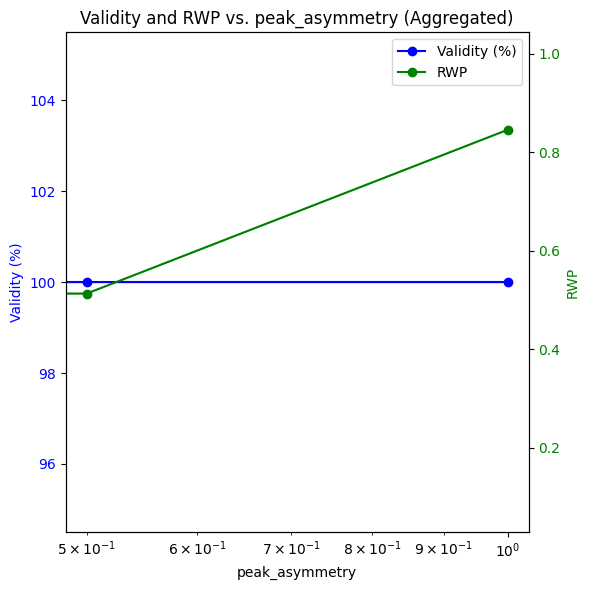

{'params': {'peak_asymmetry': -1.0, 'base_fwhm': 0.1}, 'repeat': 0, 'pxrd_ref': {'q': array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.1       , 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.2       , 0.21      , 0.22      , 0.22999999, 0.24      ,
       0.25      , 0.26      , 0.26999998, 0.28      , 0.29      ,
       0.29999998, 0.31      , 0.32      , 0.32999998, 0.34      ,
       0.35      , 0.35999998, 0.37      , 0.38      , 0.39      ,
       0.4       , 0.41      , 0.42000002, 0.43      , 0.44      ,
       0.45000002, 0.46      , 0.47      , 0.48      , 0.48999998,
       0.5       , 0.51      , 0.52      , 0.53      , 0.53999996,
       0.55      , 0.56      , 0.57      , 0.58      , 0.59      ,
       0.6       , 0.61      , 0.62      , 0.63      , 0.64      ,
       0.65      , 0.65999997, 0.66999996, 

{'params': {'peak_asymmetry': 1.0, 'base_fwhm': 0.1}, 'repeat': 0, 'pxrd_ref': {'q': array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.1       , 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.2       , 0.21      , 0.22      , 0.22999999, 0.24      ,
       0.25      , 0.26      , 0.26999998, 0.28      , 0.29      ,
       0.29999998, 0.31      , 0.32      , 0.32999998, 0.34      ,
       0.35      , 0.35999998, 0.37      , 0.38      , 0.39      ,
       0.4       , 0.41      , 0.42000002, 0.43      , 0.44      ,
       0.45000002, 0.46      , 0.47      , 0.48      , 0.48999998,
       0.5       , 0.51      , 0.52      , 0.53      , 0.53999996,
       0.55      , 0.56      , 0.57      , 0.58      , 0.59      ,
       0.6       , 0.61      , 0.62      , 0.63      , 0.64      ,
       0.65      , 0.65999997, 0.66999996, 0

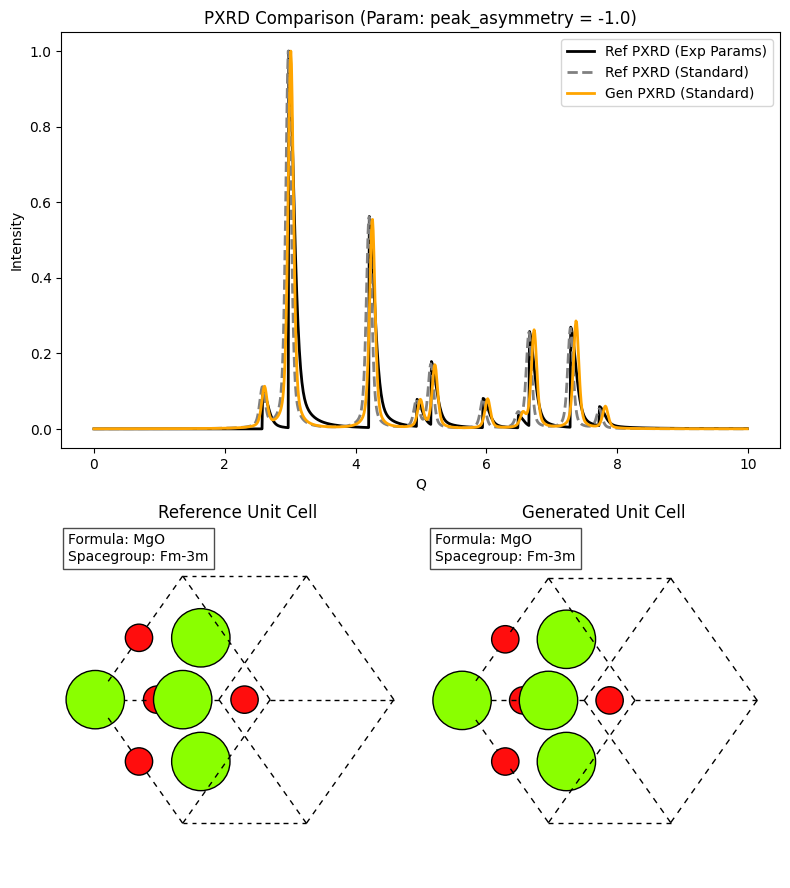

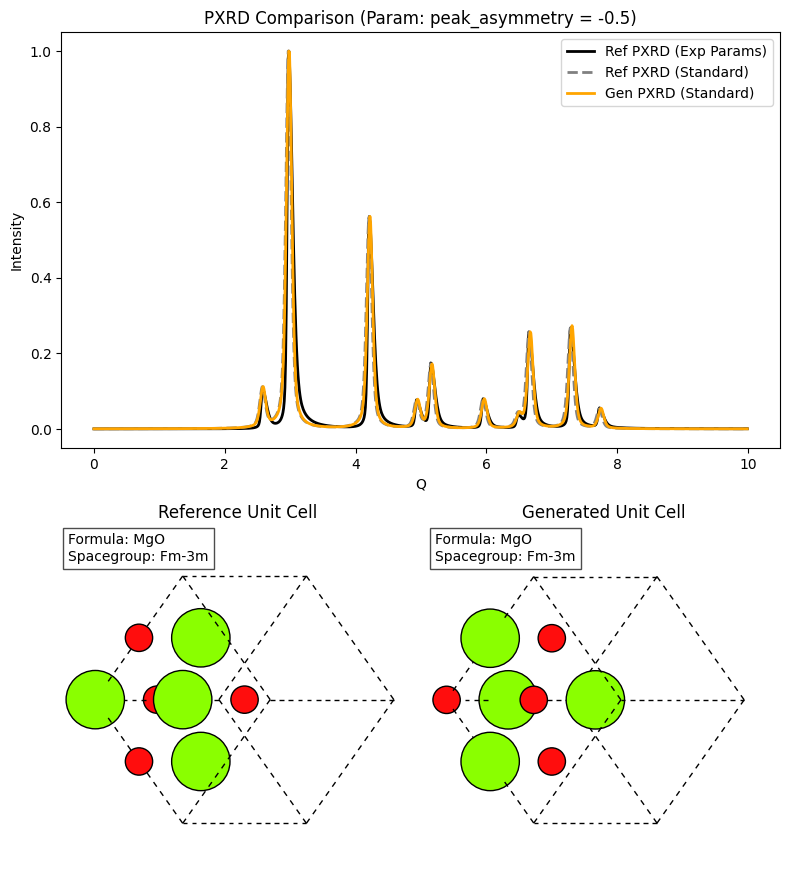

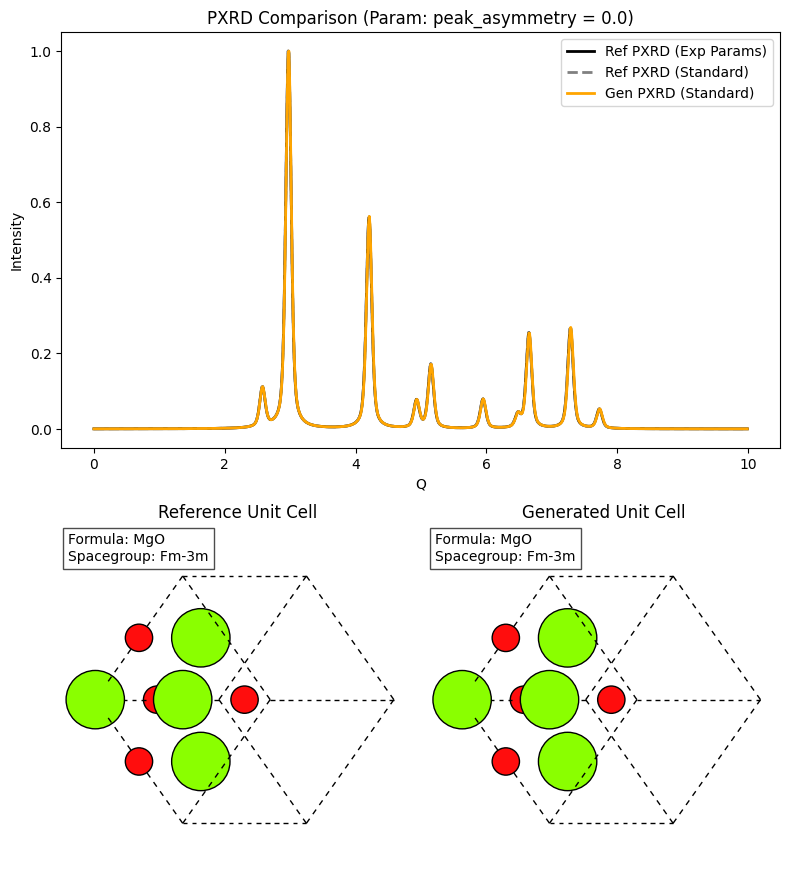

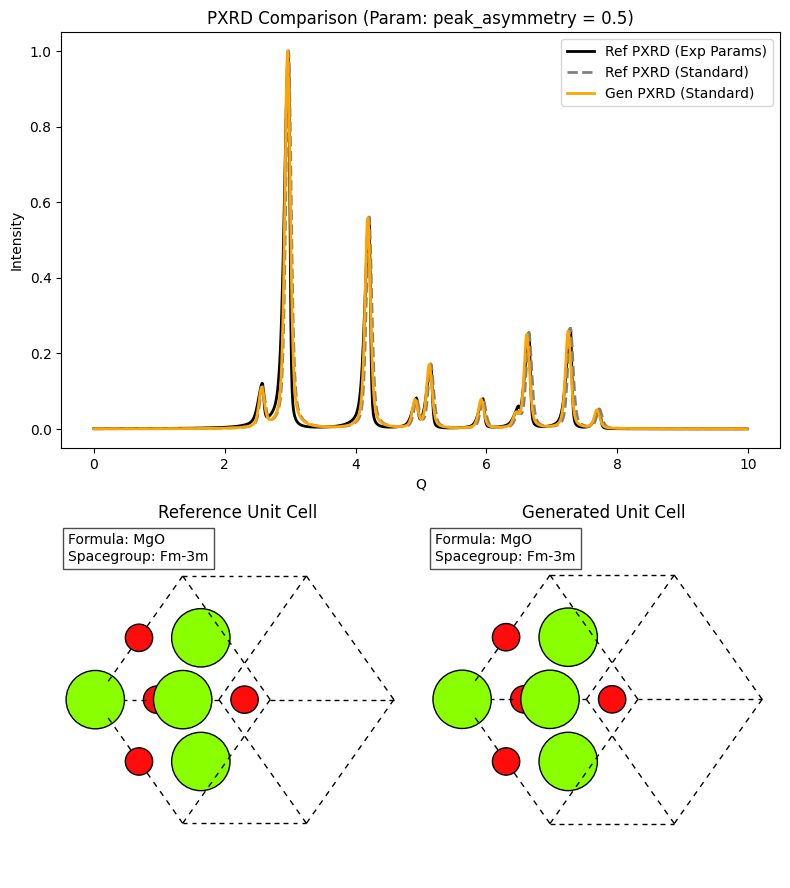

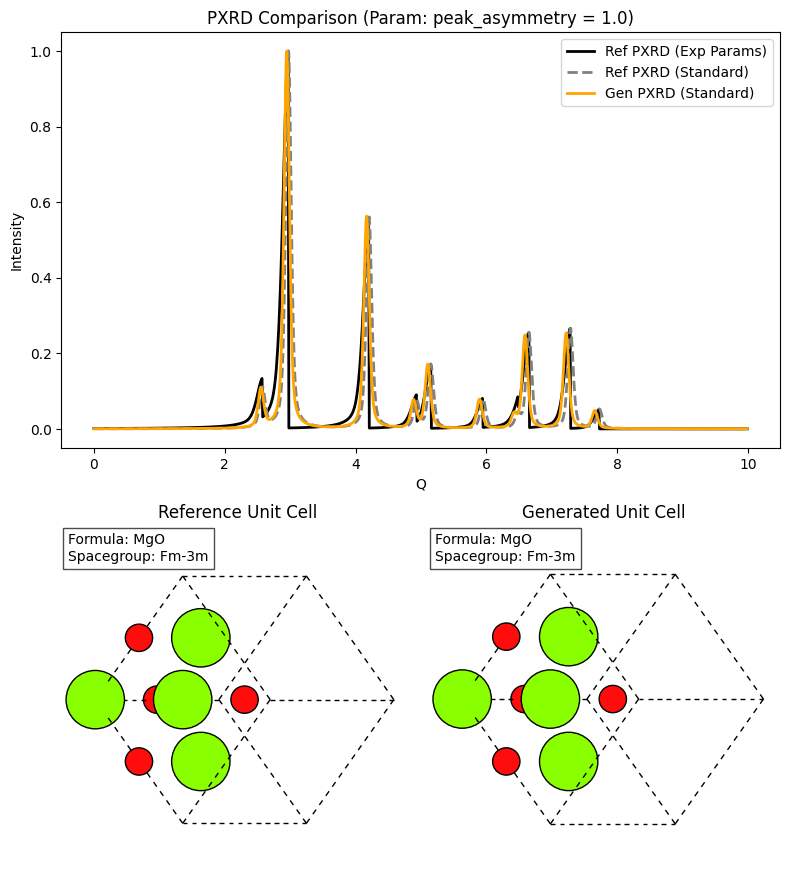

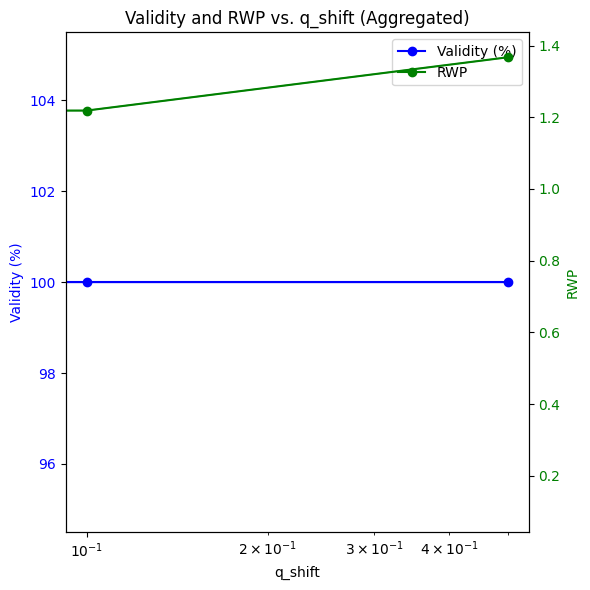

{'params': {'q_shift': -0.5, 'base_fwhm': 0.1}, 'repeat': 0, 'pxrd_ref': {'q': array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.1       , 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.2       , 0.21      , 0.22      , 0.22999999, 0.24      ,
       0.25      , 0.26      , 0.26999998, 0.28      , 0.29      ,
       0.29999998, 0.31      , 0.32      , 0.32999998, 0.34      ,
       0.35      , 0.35999998, 0.37      , 0.38      , 0.39      ,
       0.4       , 0.41      , 0.42000002, 0.43      , 0.44      ,
       0.45000002, 0.46      , 0.47      , 0.48      , 0.48999998,
       0.5       , 0.51      , 0.52      , 0.53      , 0.53999996,
       0.55      , 0.56      , 0.57      , 0.58      , 0.59      ,
       0.6       , 0.61      , 0.62      , 0.63      , 0.64      ,
       0.65      , 0.65999997, 0.66999996, 0.68   

{'params': {'q_shift': 0.5, 'base_fwhm': 0.1}, 'repeat': 0, 'pxrd_ref': {'q': array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.1       , 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.2       , 0.21      , 0.22      , 0.22999999, 0.24      ,
       0.25      , 0.26      , 0.26999998, 0.28      , 0.29      ,
       0.29999998, 0.31      , 0.32      , 0.32999998, 0.34      ,
       0.35      , 0.35999998, 0.37      , 0.38      , 0.39      ,
       0.4       , 0.41      , 0.42000002, 0.43      , 0.44      ,
       0.45000002, 0.46      , 0.47      , 0.48      , 0.48999998,
       0.5       , 0.51      , 0.52      , 0.53      , 0.53999996,
       0.55      , 0.56      , 0.57      , 0.58      , 0.59      ,
       0.6       , 0.61      , 0.62      , 0.63      , 0.64      ,
       0.65      , 0.65999997, 0.66999996, 0.68    

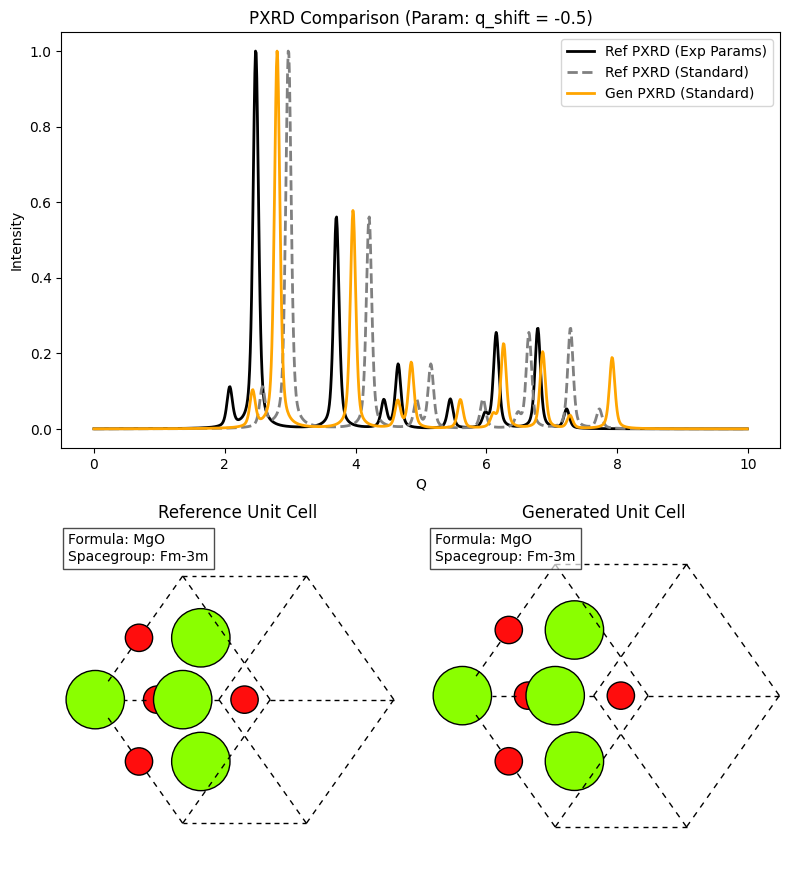

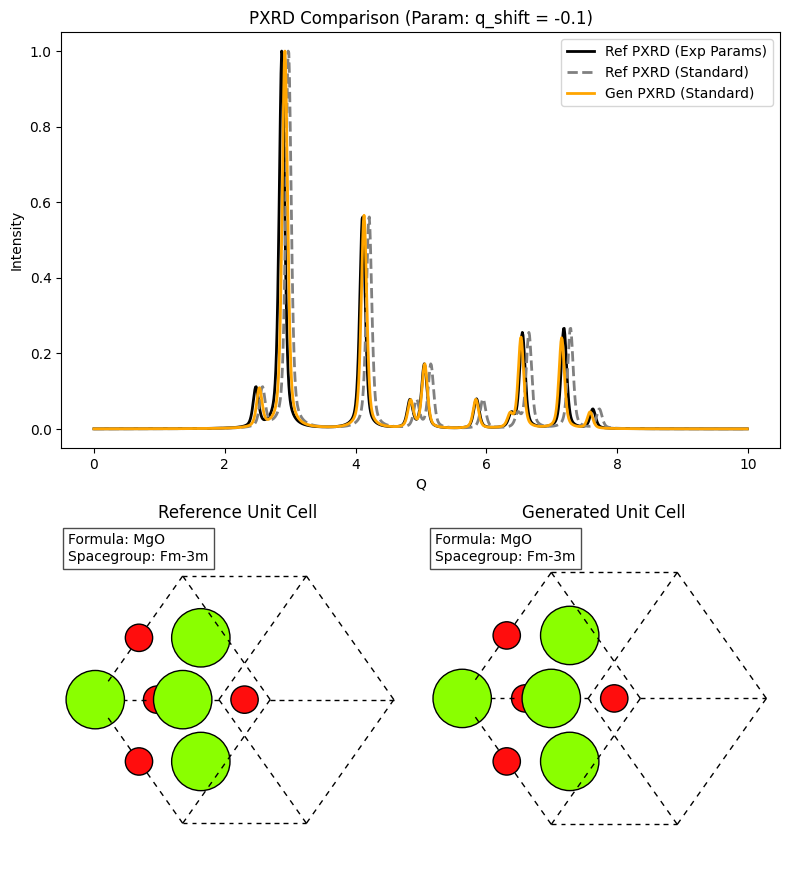

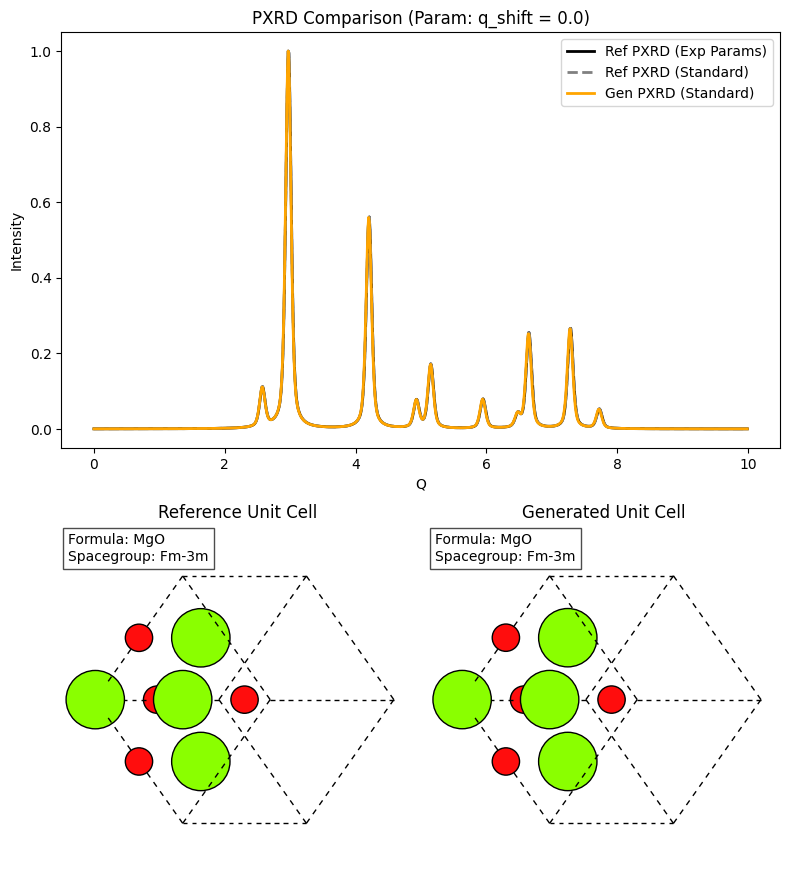

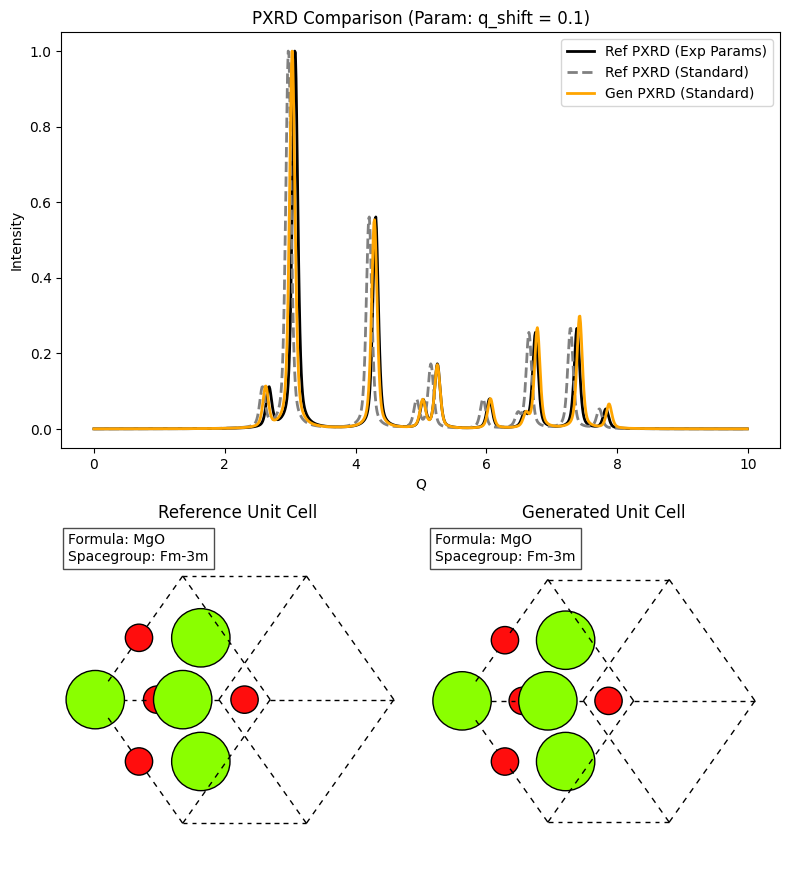

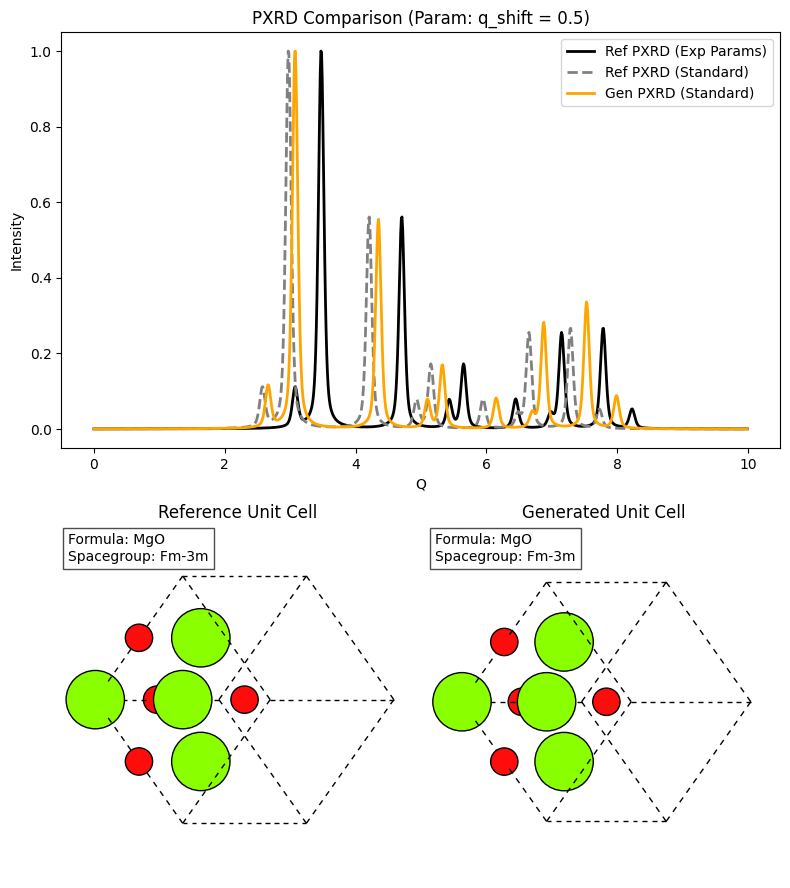

In [151]:
combined_analysis_and_visualization("../broad_experimental_results_compsg.pkl",
                                    "peak_asymmetry", prefix="compsg", folder="combined")
combined_analysis_and_visualization("../broad_experimental_results_compsg.pkl",
                                    "q_shift", prefix="compsg", folder="combined")

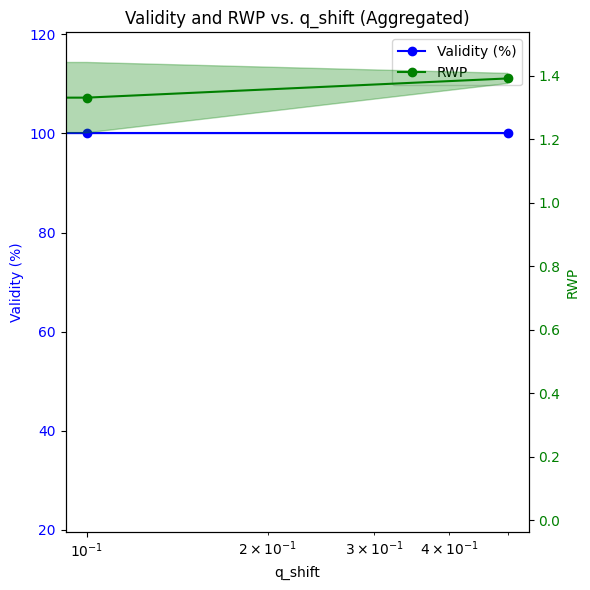

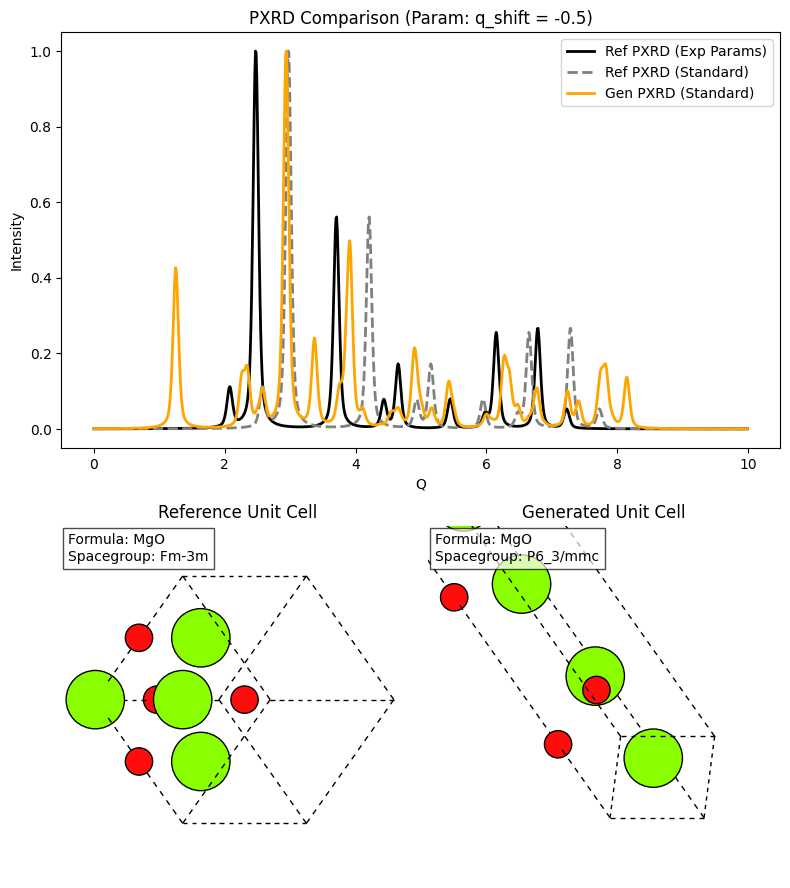

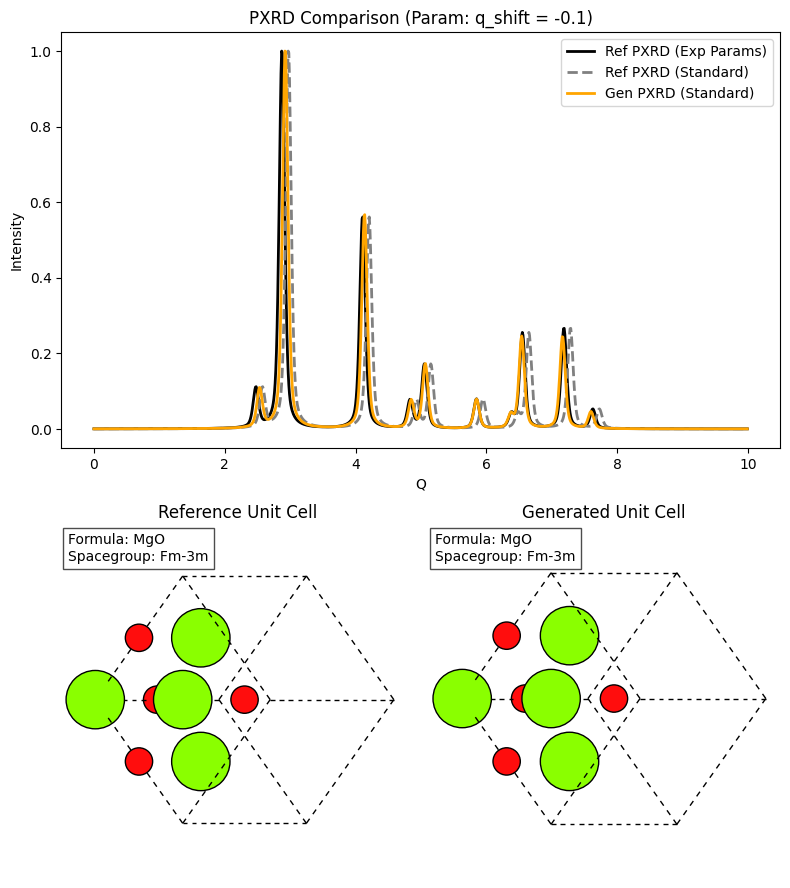

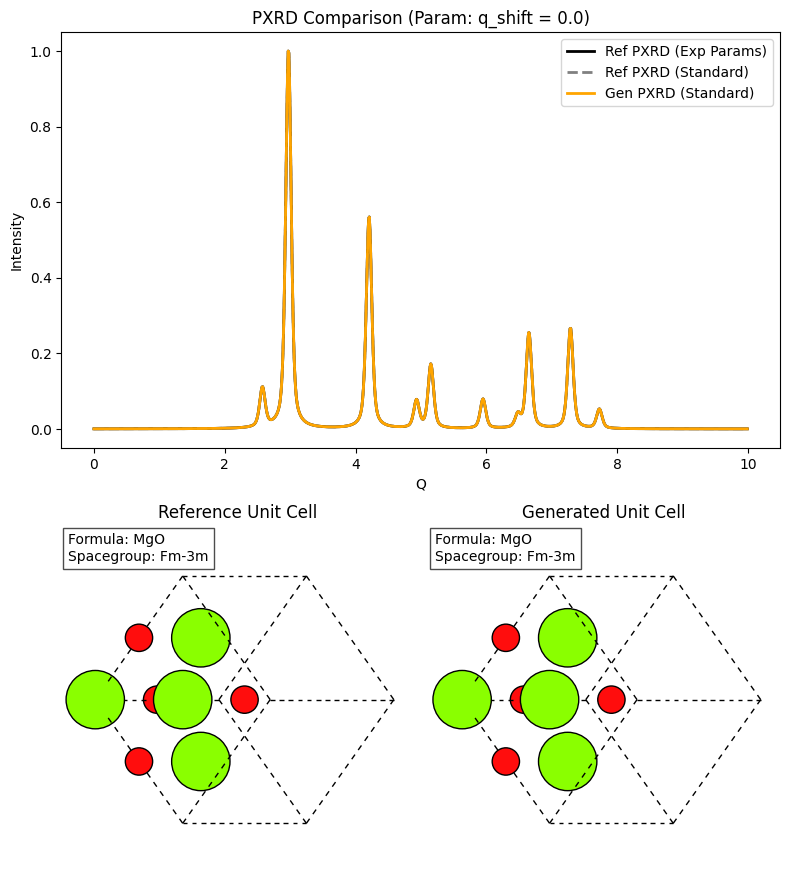

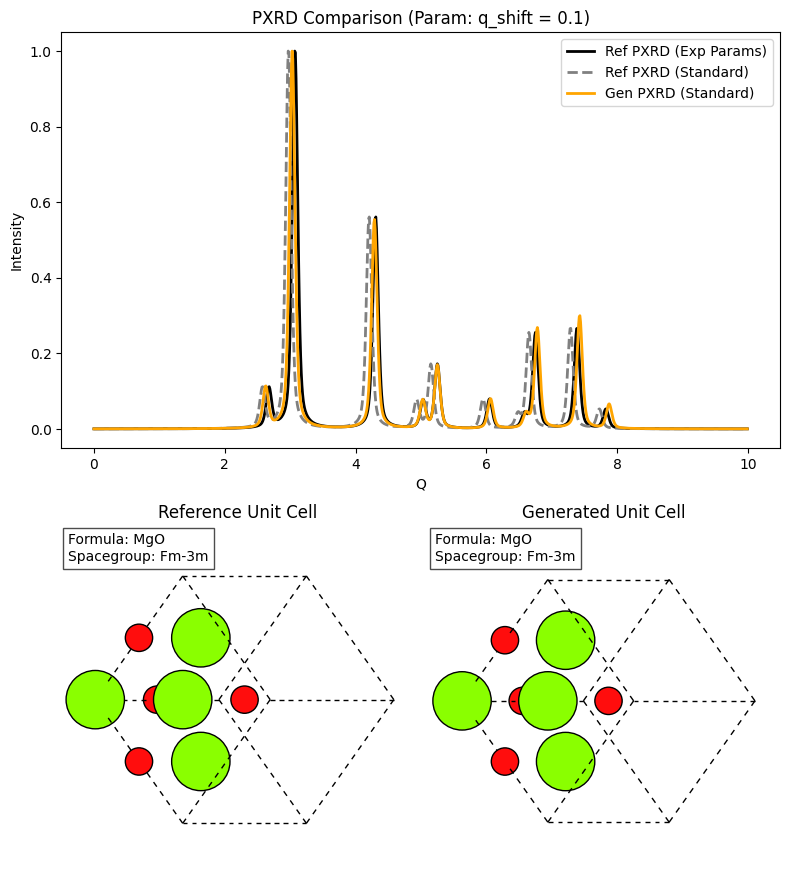

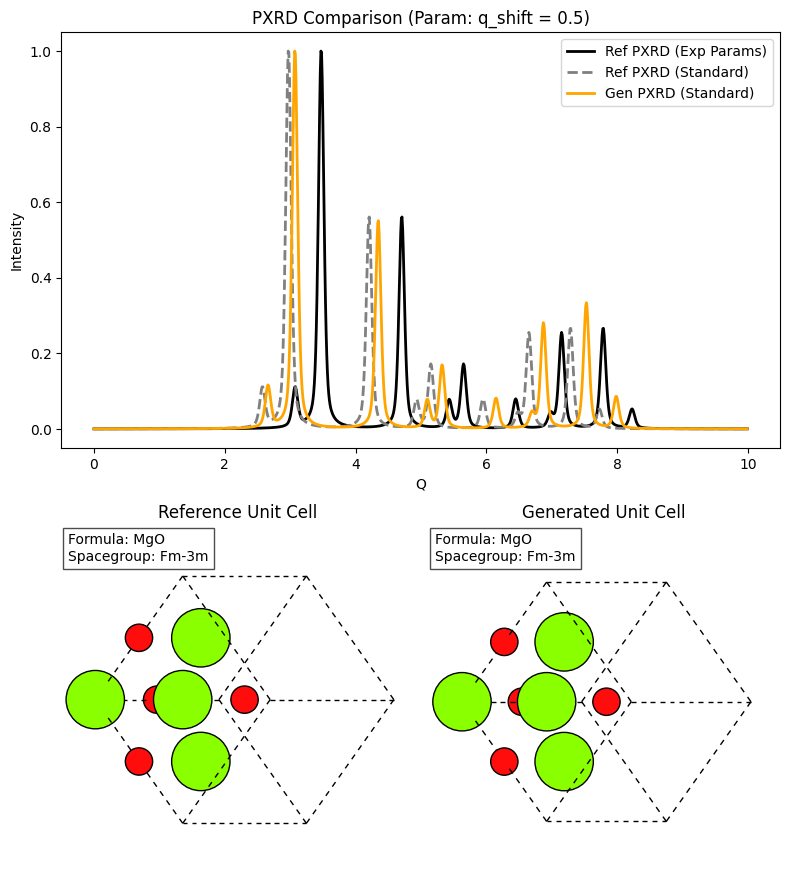

In [161]:
combined_analysis_and_visualization("../broad_experimental_results_comp.pkl",
                                    "q_shift", prefix="comp", folder="combined")

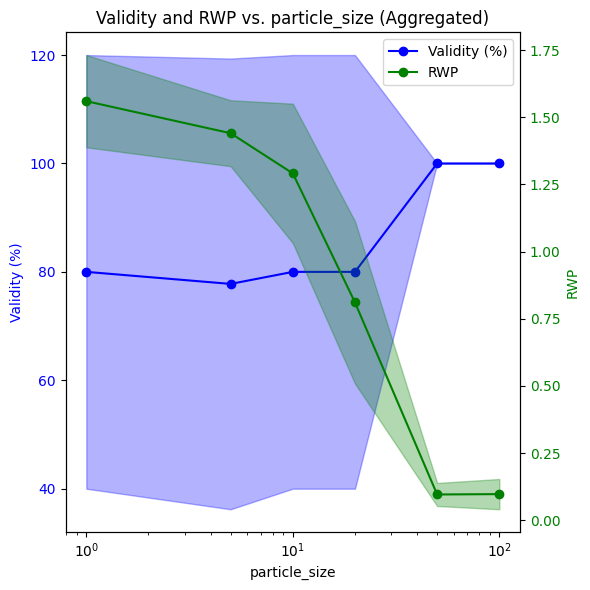

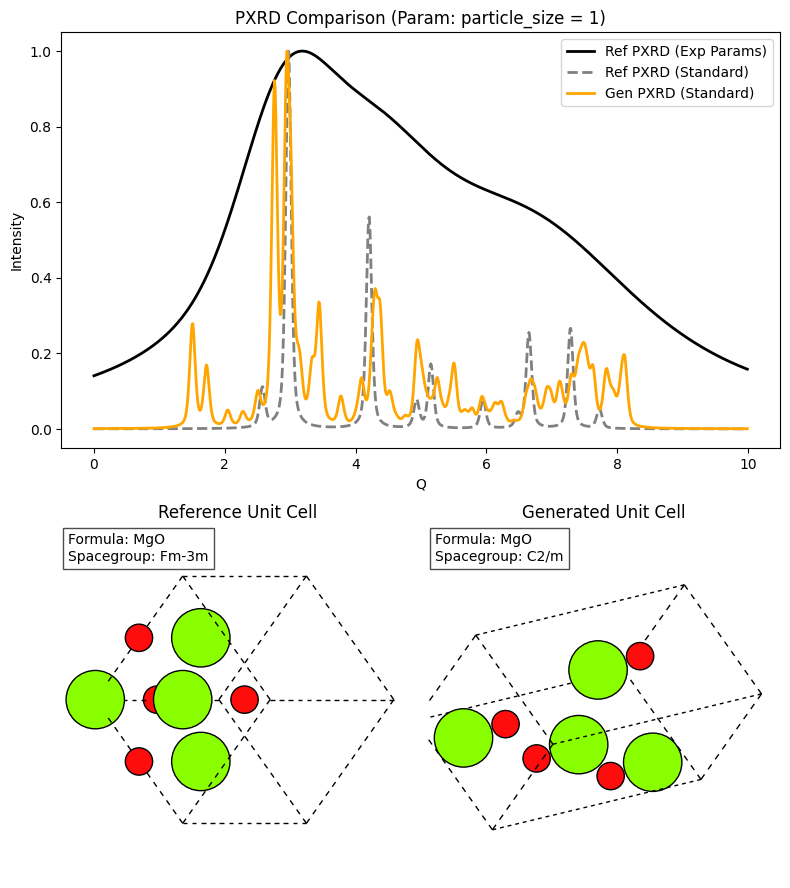

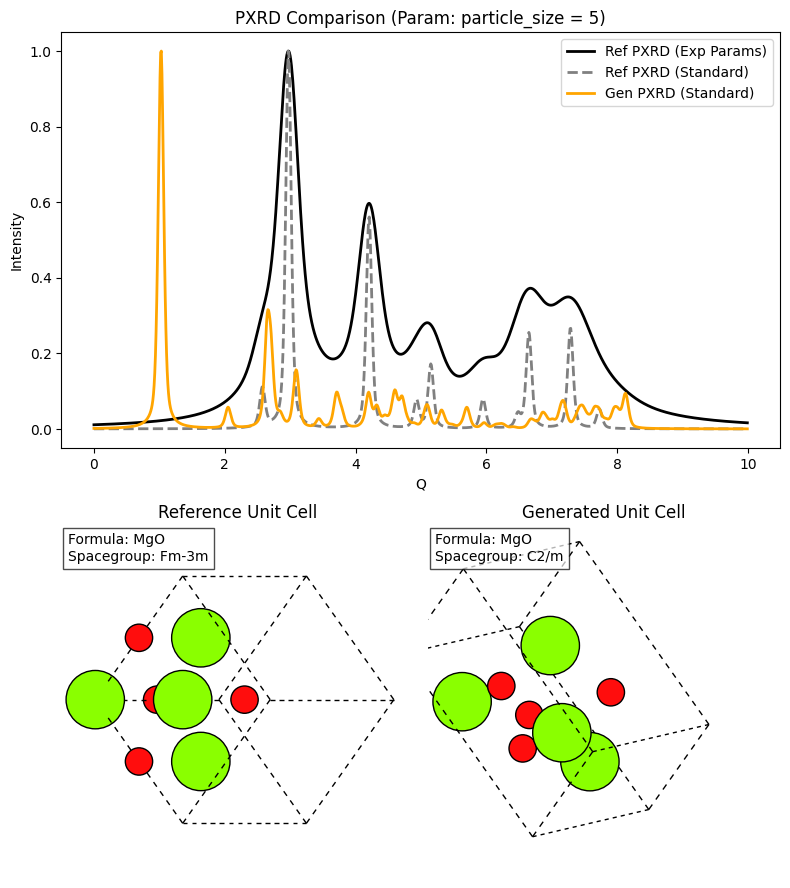

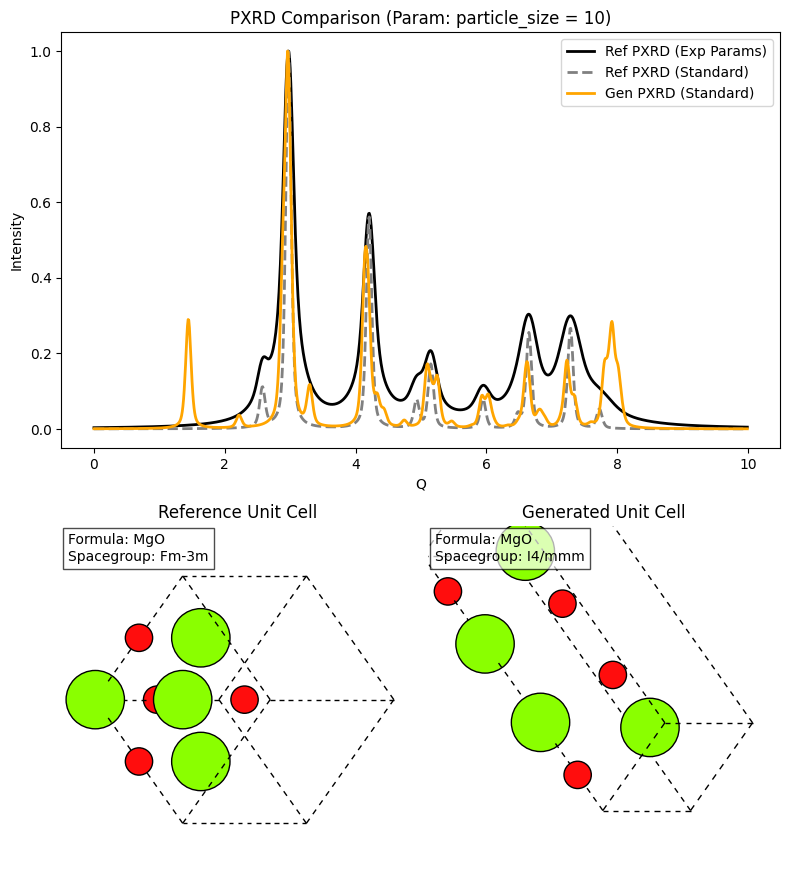

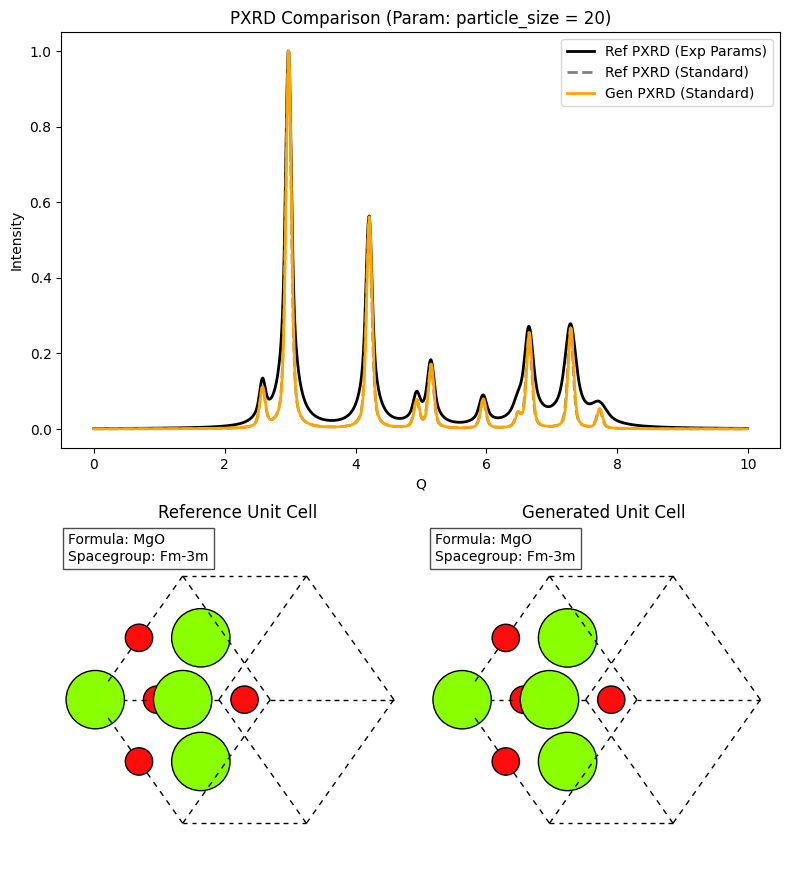

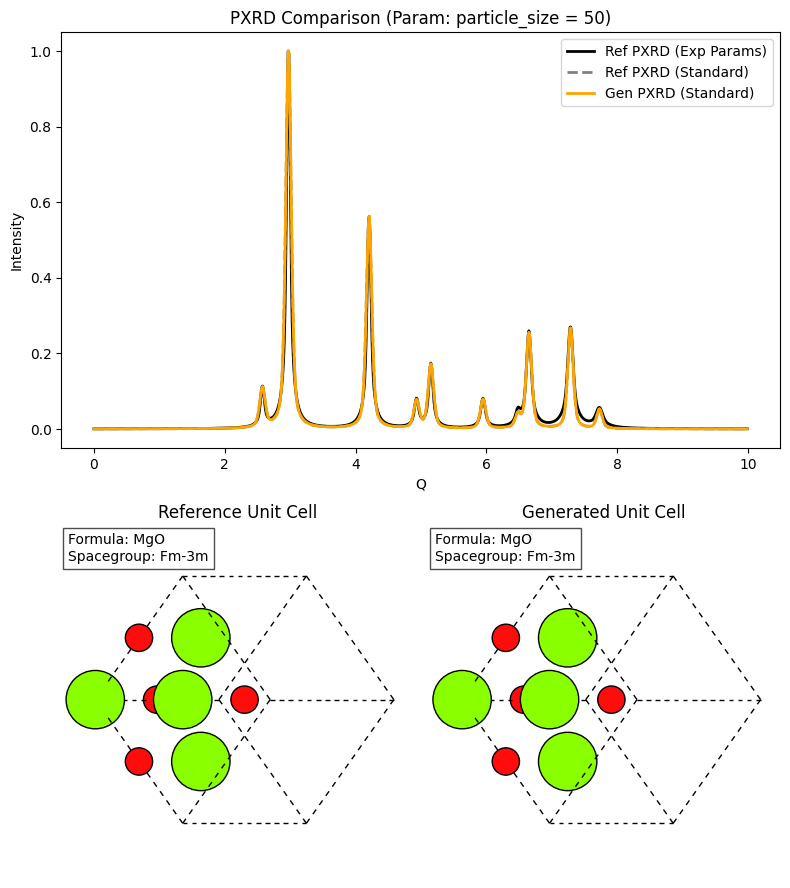

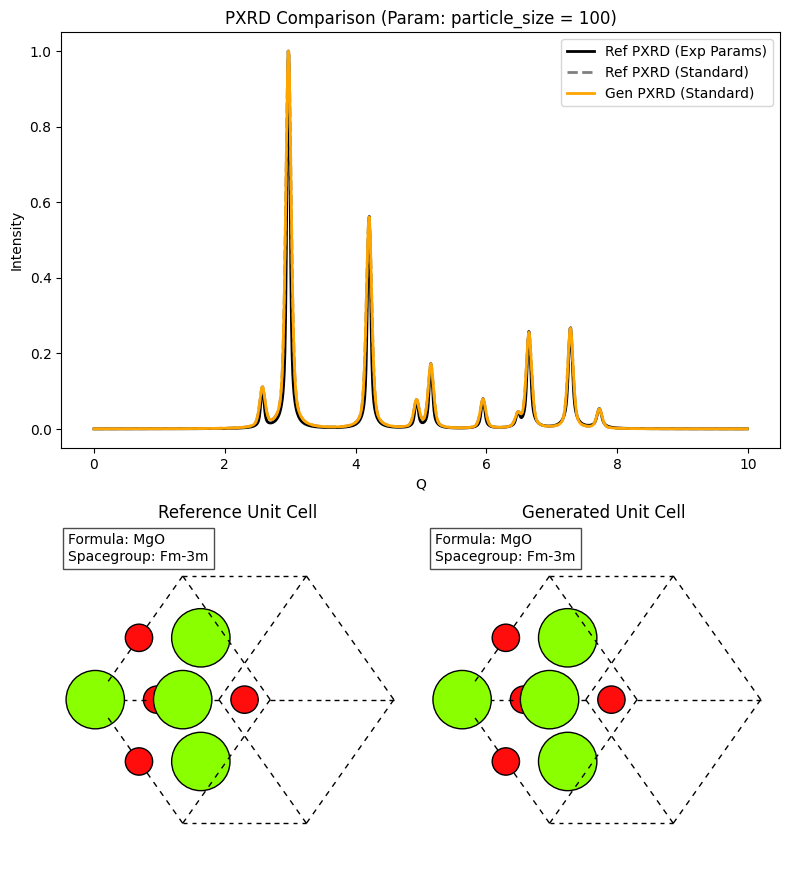

In [163]:
combined_analysis_and_visualization("../particle_size_experimental_results_comp.pkl",
                                    "particle_size", prefix="comp", folder="particle_size_comp")